In [1]:
import math
import numpy as np
import pandas as pd
import sys
import itertools
from functions import *
from mining_functions import *
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

# Story line
This notebook raises and explores hypotheses generated fom the analysis in the notebook  "temporal_sequence_infogain_mining.ipynb"

Here are the Hypotheses:
* CTsPTsP (HL)
    * TsP
        * Ts (**1.1**)
        * TP (**1.2**)
    * TsPTsP
        * TPTP (**2.1**)
* PCTcCTcC (LL)
    * TcC
        * Tc (**3.1**)
        * TC (**3.2**)
    * TcCTcC
        * TCTC (**4.1**)
* PCPCTcC (LL)
    * PC (**5.1**)
    * CP (**5.2**)
* PTsPC (HL)
    * PTs
    * PT (**6**)

## Frequency analysis of single blocks of actions -> Hypotheses 1.1 and 3.1
First we get the sequence of action of each students in blocks. Recall that we only look at students who had a low pre.
We also ignore the Interface (I) becasue they aren't interesting and we ignore the Test Other (To) because only 8 students do it.

In [3]:
students_Lpre = set(get_students('split pre','low'));H_post = set(get_students('split post t2','high'));L_post = set(get_students('split post t2','low'))
students_HL = H_post.intersection(students_Lpre)
students_LL = L_post.intersection(students_Lpre)
print "There are {0} low pre students, of which {1} are high learners and {2} low learners.".format(len(students_Lpre),len(students_HL),len(students_LL))

There are 74 low pre students, of which 38 are high learners and 36 low learners.


In [4]:
blocks_HL, time_coords_HL =  get_blocks_withTime_new(df,students_HL,"Family",start=False,ignore=['I','To'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,students_LL,"Family",start=False,ignore=['I','To'], as_list=True)
blocks_Lpre, time_coords_Lpre =  get_blocks_withTime_new(df,students_Lpre,"Family",start=False,ignore=['I','To'], as_list=True)

We may need to plot sequences so let's load them up

In [5]:
CUT_OFF = 0.35 #we keep only sequences used once by at least 20% of students
shortest_seq_length = 1
longest_seq_length = 10
B = 4  #number of bins
family_category = "Family"
sequence_counts = get_sequence_use_by_timebin(df,students_Lpre,family_category,
                                                          B,'split post t2','high','low',
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)

Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


In [6]:
#get all actions
actions = set(['C', 'P', 'Ts', 'Tb', 'Tc'])
freqs_HL = {s:{a:0 for a in actions} for s in students_HL}
freqs_LL = {s:{a:0 for a in actions} for s in students_LL}
for student,seq in blocks_HL.iteritems():
    for action in seq:
        freqs_HL[student][action]+=1
for student,seq in blocks_LL.iteritems():
    for action in seq:
        freqs_LL[student][action]+=1

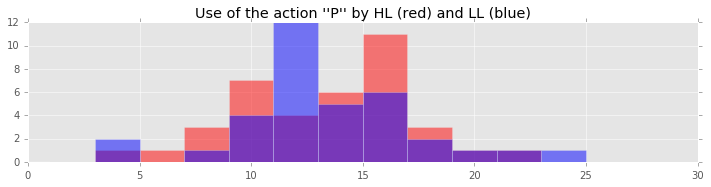

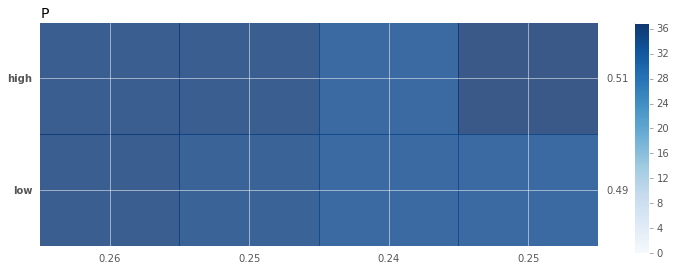

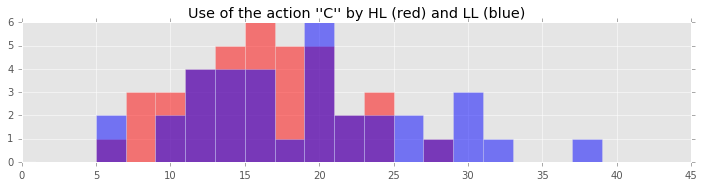

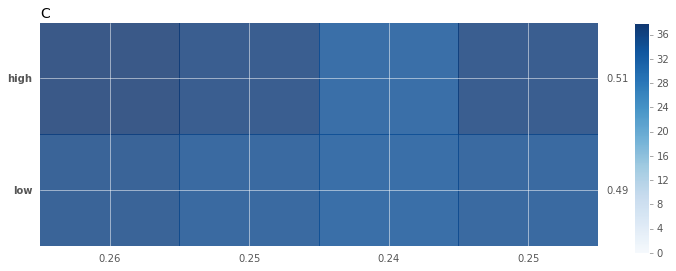

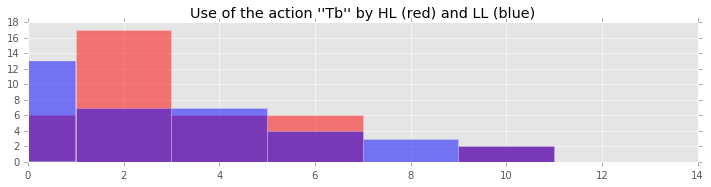

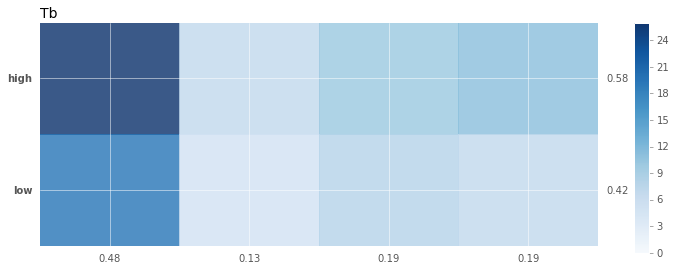

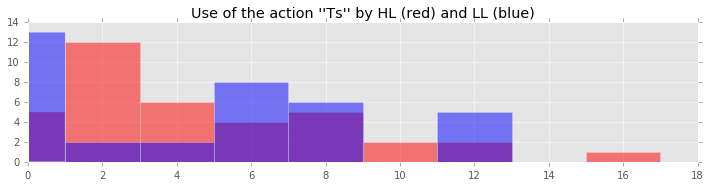

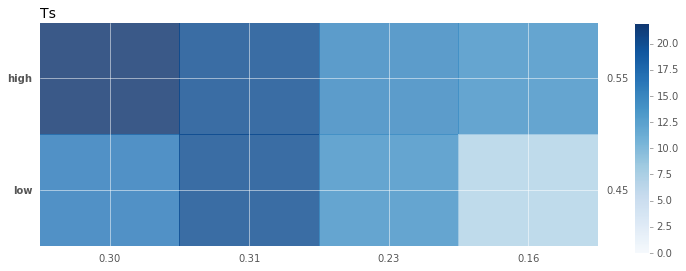

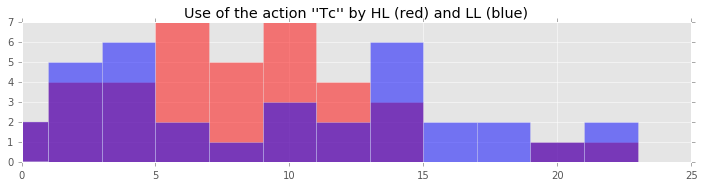

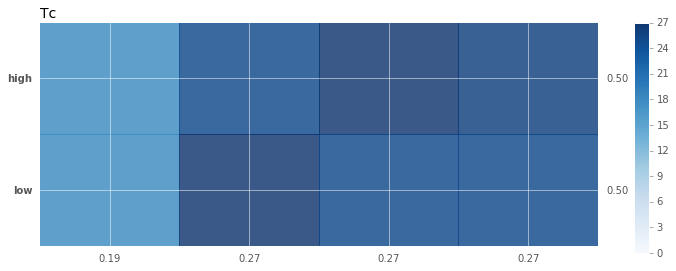

In [9]:
for action in actions:
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    plt.title("Use of the action ''{0}'' by HL (red) and LL (blue)".format(action))
    counts_HL = [f[action] for f in freqs_HL.values()]
    counts_LL = [f[action] for f in freqs_LL.values()]
    ymax= max(max(counts_HL),max(counts_LL))
    plt.hist(counts_HL,color ='r',alpha = 0.5,bins = [0]+range(1,ymax,2))
    plt.hist(counts_LL,color = 'b',alpha = 0.5,bins = [0]+range(1,ymax,2))
    plot_heat_map(sequence_counts[action],action,('high','low'))

#### We notice that some students never Test simple (13 LL and 5 HL)
Also several LL do many many Test complex actions, and perhaps have more Construct blocks. 
Everyone Test simple and basic early as well as Test complex late.
But overall, nothing very conclusive

## Let's start digging into our Hypotheses
### Hypothesis 1.2: HL do more TsP?